In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


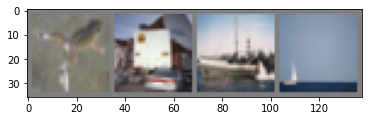

frog  truck ship  ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np



def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
PATH = './cifar_net.pth'


In [ ]:
import torch
import torch.nn as nn


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):


    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64):
        super(Bottleneck, self).__init__()
  
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)

        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * 4)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64):
        super(ResNet, self).__init__()
  

        self.inplanes = 64


        self.groups = groups

        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(Bottleneck, 64, 3)

        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)

        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)

        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
 
        downsample = None

        if stride != 1 or self.inplanes != planes * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * 4),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width))
        self.inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x




net = ResNet()
net.load_state_dict(torch.load(PATH))
net = net.cuda()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cifar_net.pth to cifar_net (1).pth


In [ ]:
net = ResNet()
net.load_state_dict(torch.load(PATH))
net = net.cuda()
criterion = nn.CrossEntropyLoss()


In [ ]:
def downsample(x, step=1):
    down = torch.zeros([len(x), 3, 32//step, 32//step])

    for i in range(0, 32, step):
        for j in range(0, 32, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down
from torch.distributions.multivariate_normal import MultivariateNormal

im_test, targ_test = [], []
for _, (im, targ) in enumerate(testloader):
    im_test.append(im)
    targ_test.append(targ)
im_test, targ_test = torch.cat(im_test), torch.cat(targ_test)

conditionals = []
for i in range(10):
    imc = im_test[targ_test == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*torch.eye(3 * 32* 32))
    conditionals.append(dist)

In [ ]:
img_seed = torch.stack([conditionals[i].sample().view(3, 32//1, 32//1) 
                     for i in range(8)])
img_seed = torch.clamp(img_seed, min=0, max=1)


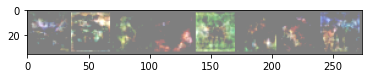

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


imshow(torchvision.utils.make_grid(img_seed))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


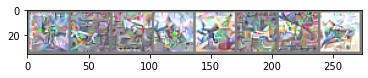

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


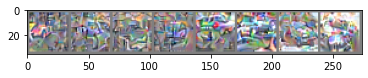

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


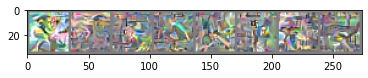

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


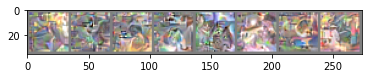

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


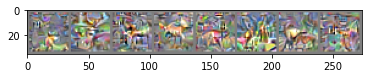

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


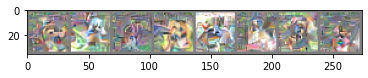

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


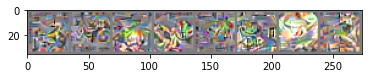

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


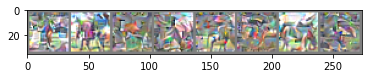

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


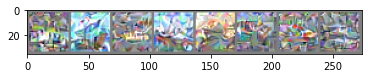

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


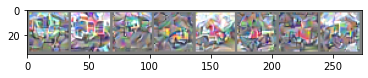

Finished Training


In [ ]:
for i in range(10):
  target_class = i * torch.ones((8, )) 
  im_seed = torch.stack([conditionals[int(t)].sample().view(3, 32, 32) 
                        for t in target_class])
    
  im_seed = torch.clamp(im_seed, min=0, max=1)
  inputs, labels = torch.tensor(im_seed).cuda(), target_class.long().cuda()
  inputs.requires_grad_(True)
  net.requires_grad_(False)
  parameters = [
     {'params': net.parameters()},
     {'params': [inputs], 'lr': 10}
  ]
  optimizer = optim.SGD(parameters, lr = 10)
  for epoch in range(500):  
    
      running_loss = 0.0

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()


      running_loss += loss.item()
  inputs1 = inputs.cpu()
  imshow(torchvision.utils.make_grid(inputs1))
  print('Finished Training')

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def mask_image(img, width=8):
    x = img
    loc = np.random.randint(0, x.shape[-1] - 8, size=(x.shape[0], 2))
    mask = torch.zeros_like(x)
    for idx in range(x.shape[0]):
        i, j = loc[idx, 0], loc[idx, 1]
        val = torch.mean(torch.mean(x[idx, :], dim=2, keepdim=True), dim=1, keepdim=True)
        # Initialize masked region as mean pixel value over image (per channel)
        x[idx, :, i:i+8, j:j+8] = val.expand_as(x[idx, :, i:i+8, j:j+8])
        mask[idx, :, i:i+8, j:j+8] = 1
    return x, mask

In [ ]:
img = images.clone()
x, mask = mask_image(images)


In [ ]:
def loss(img1, img2, mask, op, targ):
  loss = 0
  loss += nn.CrossEntropyLoss()(reduction='none')(op, targ).mean()
  loss += (((img1 - img2) * (1 - mask) )**2).mean(-1).mean(-1).mean(-1).mean()
  return loss

In [ ]:
criterion = nn.CrossEntropyLoss()
data_iterator = enumerate(testloader)



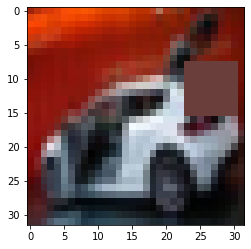

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.1240, device='cuda:0', grad_fn=<AddBackward0>)


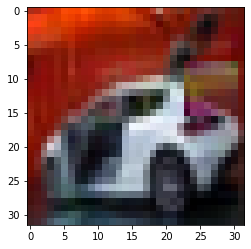

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.0836, device='cuda:0', grad_fn=<AddBackward0>)


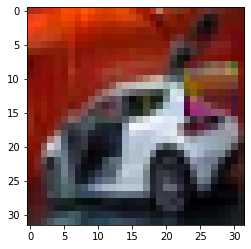

Finished Training


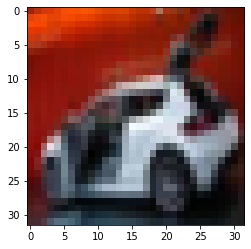

In [ ]:
  _, (corupt, targ_orig) = next(data_iterator)
  orig = corupt.clone()
  images = images.cpu().detach()
  corupt, mask = mask_image(corupt)
  imshow(torchvision.utils.make_grid(corupt))
  corupt = corupt.cuda()
  targ_orig = targ_orig.cuda()
  mask = mask.cuda()
  orig = orig.cuda()
  labels = labels.cuda()
  corupt.requires_grad_(True)
  net.requires_grad_(False)
  parameters = [
     {'params': net.parameters()},
     {'params': [corupt], 'lr': 0.1}
  ]
  optimizer = optim.SGD(parameters, lr = 0.1)
for epoch in range(2000):  # loop over the dataset multiple times
    #optimizer = optim.SGD([inputs], lr=0.5, momentum=0.9)
      running_loss = 0.0
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
      optimizer.zero_grad()

        # forward + backward + optimize
      outputs = net(corupt)
      loss = criterion(outputs, targ_orig) + (((orig - corupt) * (1 - mask) )**2).mean(-1).mean(-1).mean(-1).mean()*100
      loss.backward()
      optimizer.step()


        # print statistics
      running_loss += loss.item()
      inputs1 = corupt.cpu().detach()
      
      if epoch %1000 == 999:
        print(loss)
        imshow(torchvision.utils.make_grid(inputs1))
        print('Finished Training')
orig = orig.cpu().detach()
imshow(torchvision.utils.make_grid(orig))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')